# How to use the algorithm Orthogonal Matching Pursuit - OMP on a DataTime object

The SciDataTool python module has been created to **ease the handling of scientific data**, the DataND method `orthogonal_mp` allow to recover a signal with missing time samples assuming the signal has a sparse representation in the Fourier space, which means the signal is compressible.

Given a DataTime object, build upon a non uniform axe Data1D, we want to compute the spectrum of the DataTime object.

There are 2 different way to implement this reconstruction:
1. Greedy algorithm -> OMP
2. Linear system with $l_1$ constraint -> Basis Pursuit

This implementation uses the greedy function `sklearn.linear_model.orthogonal_mp` from the package `scikit-learn`. The glossary and the formalism used in `scikit-learn` is closed from the machine learning / statistics ones, so the documentation can be quite different from the usual formalism used in signal processing, a greedy algorthm is called a forward feature selection.

The dictionary used is a concatenation of the DCT - Discrete Cosinus Transform - matrix and of the DST - Discrete Sinus Transform - matrix.

The following explains how to use `DataND.orthogonal_mp` method.


In [19]:
from SciDataTool.Classes.DataTime import DataTime
from SciDataTool.Classes.Data1D import Data1D
from SciDataTool.Classes.DataND import DataND

import numpy as np

from math import floor

In [20]:
import scipy.fft as spfft

from sklearn.linear_model import orthogonal_mp

#### Example:
Create a signal of $2$ sinudoids with $n=100$ points, it's then undersampled with only $K=30$% of the grid.

We plot the $2$ signals and the spectrum.

In [4]:
n = 100

t = np.linspace(0,1,n,endpoint=False)

# Create a undersampled time vector with 30% of the initial samples
K = 0.30
m = floor(K*n)
M = np.random.choice(n,m, replace=False)
M.sort()

signal = np.sin(2*np.pi*2*t+0.2) + 0.5*np.sin(2*np.pi*10*t+2)
signal_under = signal[M]

Time = Data1D(name="time", unit="s", values=t)
Time_under = Data1D(name="time", unit="s", values=t[M])

Signal = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal,
    is_real=True,
)

Signal_under = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under,
    is_real=True,
)

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


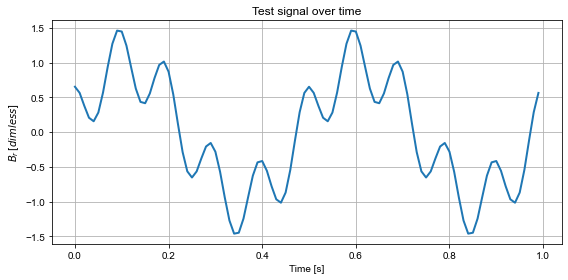

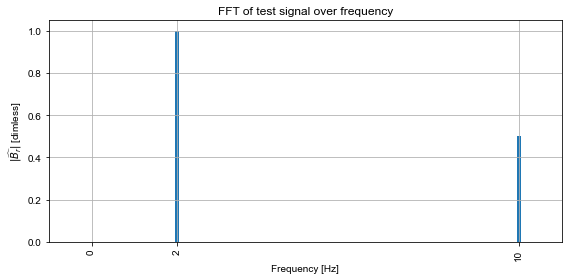

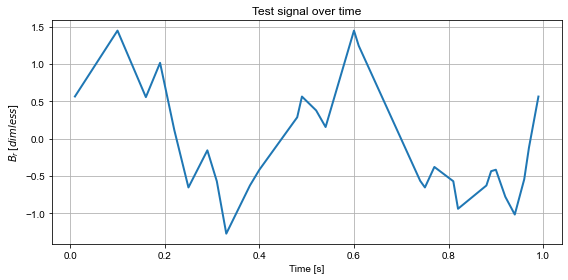

In [5]:
Signal.plot_2D_Data("time")

Signal.plot_2D_Data("freqs")

Signal_under.plot_2D_Data("time")

### Recover of the full signal:

In [21]:
Signal_recover = Signal_under.orthogonal_mp(Time)

Signal.plot_2D_Data("time",data_list=[Signal_recover])
Signal.plot_2D_Data("freqs",data_list=[Signal_recover])


AssertionError: Dimension error: %d != 2

# The dictionary - DCT and DST

Change `i` in order to plot the atoms of the dictionary on which the signal is projected.

(100, 100)


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


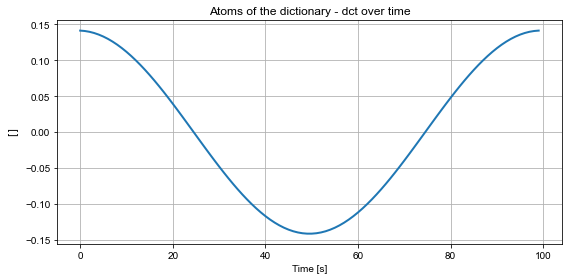

In [8]:
# Compute the dictionary's matrix of the DCT
DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)

# Plot the i-th column of A -> the i-th atom of the dictionary
i = 2

print(DCT.shape)

axe_time = Data1D(
    name="time",
    values=np.asarray([i for i in range(n)]),
    )

atom = DataTime(
    name="Atoms of the Dictionary - DCT",
    axes=[axe_time],
    values=DCT[:,i],
    )

atom.plot_2D_Data("time")

We will use a dictionary which is the concatenation of the DCT's matrix and the DST's matrix

(100, 100)


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


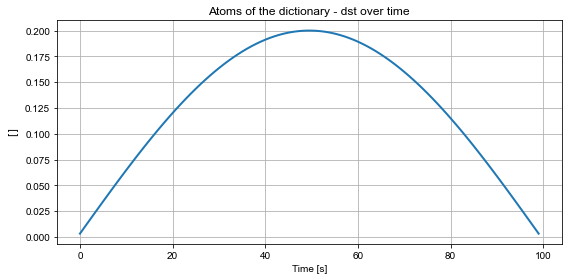

In [9]:
# Compute the dictionary's matrix of the DST
DST = spfft.idst(np.identity(n), type=2, norm='ortho', axis=0)

# Plot the i-th column of A -> the i-th atom of the dictionary
i = 0

print(DST.shape)

axe_time = Data1D(
    name="time",
    values=np.asarray([i for i in range(n)]),
    )

atom = DataTime(
    name="Atoms of the Dictionary - DST",
    axes=[axe_time],values=DST[:,i],
    )

atom.plot_2D_Data("time")

In [10]:
A = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
B = spfft.idst(np.identity(n), type=2, norm='ortho', axis=0)

A = np.concatenate([A,B],axis=1)

print(A.shape)

# a signal of 100 samples is decomposed with a set of cosinus and sinus

(100, 200)


### Decomposition

The use of the DCT and DST matrix is relevant for the following decomposition of the signal $x$:
$$
\begin{equation}
x(t) = \sum_k c_k e^{i 2 \pi f_k t}
\end{equation}
$$
$c_k = |c_k| e^{i \phi_k}$ is the complex coefficients of the $f_k$ frequency.

For a real signal:
$$
\begin{equation}
x(t) = \sum_k |c_k| \cos(\phi_k) cos(2 \pi f_k t) + \sum_k -|c_k| \sin(\phi_k) \sin(2 \pi f_k t)
\end{equation}
$$


This method recover a time domain signal using its sparse frequency domain representation. Therefore this method uses DST - DCT matrix and process a `DataTime` object.

Those could be change for different future uses.

# Orthogonal Matching Pursuit for SMV - Single Measurement Vector

OMP is a way to solve the following underdetermined linear system:

$$ y = Ax $$

where $A \in R^{m,n}$, $y \in R^m$, $x \in R^n$ and $m << n $
$A$ is the random matrix which models the undersampling.

Assuming the signal has a sparse Fourier Representation, $D$ is the matrix doing the DFT transformation has stated in the last cell.

$$ y = ADX $$

The OMP solve this system minimizing the non zero coefficients of the vector $x$.

The variable `n_coefs` is the number of non zero coefficients searched during the recovering. If set to `None`, `scikit-learn`look for $\frac{10}{m}$ non zero coefficients.

## Different Dictionaries:

The following implement the OMP with 3 different dictionaries:

1. DCT
2. DCT and Identity
3. DCT and DST

In [12]:
n_coefs = 30

def omp(signal_under,M,n,n_coefs=None):
    """OMP with only the DCT matrix"""

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    DCT = DCT[M]

    decomposition = orthogonal_mp(X=DCT,y=signal_under,n_nonzero_coefs=n_coefs)

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)

    signal = DCT @ decomposition

    return decomposition, signal

def omp_indentity(signal_under,M,n,n_coefs=None):
    """OMP with the DCT matrix and the Identity matrix"""

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    DCT = DCT[M]
    Dictionary = np.concatenate([DCT,np.identity(n)[M]],axis=1)

    decomposition = orthogonal_mp(X=Dictionary,y=signal_under,n_nonzero_coefs=n_coefs)

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    Dictionary = np.concatenate([DCT,np.identity(n)],axis=1)

    signal = Dictionary @ decomposition

    return decomposition, signal

def omp_dst(signal_under,M,n,n_coefs=None):
    """OMP with the DCT matrix and DST matrix"""

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    DCT = DCT[M]
    DST = spfft.idst(np.identity(n), type=2, norm='ortho', axis=0)
    DST = DST[M]

    Dictionary = np.concatenate([DCT,DST],axis=1)

    decomposition = orthogonal_mp(X=Dictionary,y=signal_under,n_nonzero_coefs=n_coefs)

    DCT = spfft.idct(np.identity(n), type=2, norm='ortho', axis=0)
    DST = spfft.idst(np.identity(n), type=2, norm='ortho', axis=0)

    Dictionary = np.concatenate([DCT,DST],axis=1)

    signal = Dictionary @ decomposition

    return decomposition, signal

decomposition,signal_reconstruit = omp(signal_under,M,n,n_coefs=n_coefs)

decomposition_identity, signal_reconstruit_identity = omp_indentity(signal_under,M,n,n_coefs=n_coefs)

decomposition_dst, signal_reconstruit_dst = omp_dst(signal_under,M,n,n_coefs=n_coefs)


C:\Users\Eomys\Documents\eomys\repo\virtual_env\sample\lib\site-packages\sklearn\linear_model\_omp.py:389: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  out = _cholesky_omp(


c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


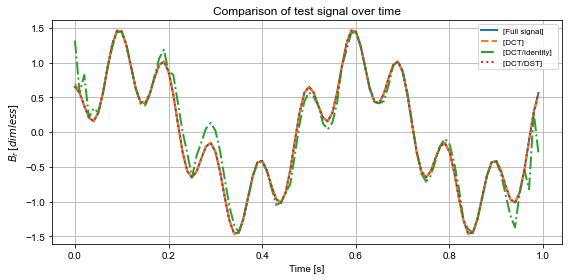

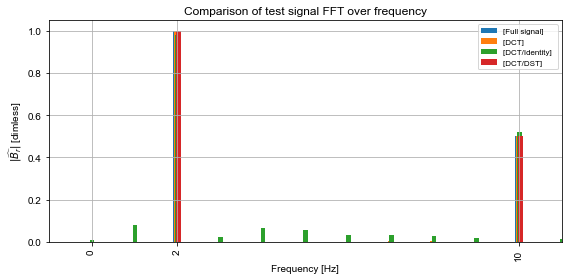

In [13]:
Signal_reconstruit = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_reconstruit,
    is_real=True,
)

Signal_reconstruit_identity = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_reconstruit_identity,
    is_real=True,
)

Signal_reconstruit_dst = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_reconstruit_dst,
    is_real=True,
)

Signal.plot_2D_Data(
    "time",
    data_list=[Signal_reconstruit,Signal_reconstruit_identity,Signal_reconstruit_dst],
    legend_list=["Full signal","DCT","DCT/Identity","DCT/DST"],
    linestyles=["-","--","-.",":"],
    )
Signal.plot_2D_Data(
    "freqs",
    data_list=[Signal_reconstruit,Signal_reconstruit_identity,Signal_reconstruit_dst],
    legend_list=["Full signal","DCT","DCT/Identity","DCT/DST"],
    )


# Orthogonal Matching Pursuit for MMV - Multiple Measurement Vector

Assume we have $\forall i \in \{1,\cdots,n_{targets}\}$

$$ y_i = Ax_i $$

where the $x_i$ vectors are jointly sparse.

We can recover these signals in one use of the OMP, by stacking the vectors $x_i$ and $y_i$ in the columns of the matrix $X$ and $Y$.

$$ Y = AX $$

This can be used to recover 2D signal, for example a time-angle signal.

c:\users\eomys\documents\eomys\repo\virtual_env\sample\src\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


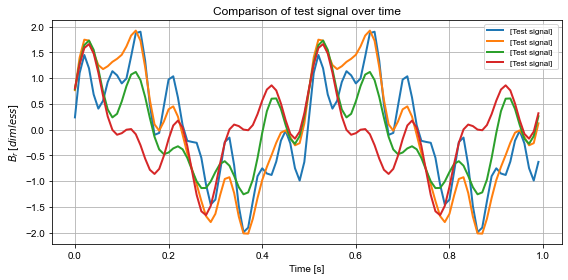

In [14]:
n = 100

t = np.linspace(0,1,n,endpoint=False)

K = 0.30
m = floor(K*n)
M = np.random.choice(n,m, replace=False)
M.sort()

signal_1 = 1.2 * np.sin(2*np.pi*2*t+0.2) + 0.5*np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*16*t)
signal_2 = 1.6 * np.sin(2*np.pi*2*t+0.5) + 0.5*np.sin(2*np.pi*10*t) + 0.2*np.sin(2*np.pi*16*t)
signal_3 = 1.0 * np.sin(2*np.pi*2*t+0.9) + 0.5*np.sin(2*np.pi*10*t) + 0.3*np.sin(2*np.pi*8*t)
signal_4 = 0.8 * np.sin(2*np.pi*2*t+1.6) + 0.5*np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*6*t)

signal_under_1 = signal_1[M]
signal_under_2 = signal_2[M]
signal_under_3 = signal_3[M]
signal_under_4 = signal_4[M]

Time = Data1D(name="time", unit="s", values=t)
Time_under = Data1D(name="time", unit="s", values=t[M])

Signal_1 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_1,
    is_real=True,
)

Signal_2 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_2,
    is_real=True,
)

Signal_3 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_3,
    is_real=True,
)

Signal_4 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=signal_4,
    is_real=True,
)

Signal_under_1 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under_1,
    is_real=True,
)

Signal_under_2 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under_2,
    is_real=True,
)

Signal_under_3 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under_3,
    is_real=True,
)

Signal_under_4 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time_under],
    values=signal_under_4,
    is_real=True,
)

Signal_1.plot_2D_Data("time",data_list=[Signal_2,Signal_3,Signal_4])

## Post-Processing
stack the signals in the columns of a matrix `signal_under_mmv`

In [ ]:
signal_under_1 = signal_under_1.reshape(-1,1)
signal_under_2 = signal_under_2.reshape(-1,1)
signal_under_3 = signal_under_3.reshape(-1,1)
signal_under_4 = signal_under_4.reshape(-1,1)

print(signal_under_1.shape)

signal_under_mmv = np.concatenate([signal_under_1,signal_under_2,signal_under_3,signal_under_4],axis=1)

print(signal_under_mmv.shape)

decomposition_dst, signal_reconstruit_dst = omp_dst(signal_under_mmv,M,n,n_coefs=n_coefs)

print(decomposition_dst.shape)
print(signal_reconstruit_dst.shape)

s1 = signal_reconstruit_dst[:,0]
s2 = signal_reconstruit_dst[:,1]
s3 = signal_reconstruit_dst[:,2]
s4 = signal_reconstruit_dst[:,3]

c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\users\eomys\documents\eomys\repo\install_source\scidatatool\SciDataTool\Functions\Plot\plot_2D.py:388: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so canno

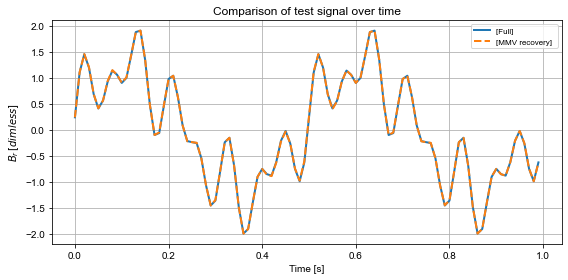

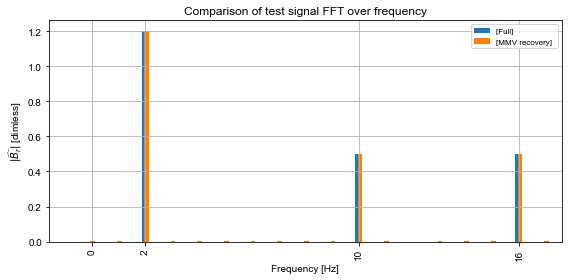

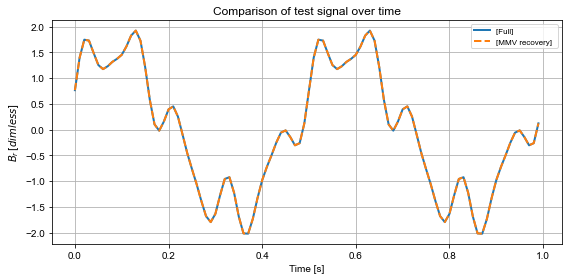

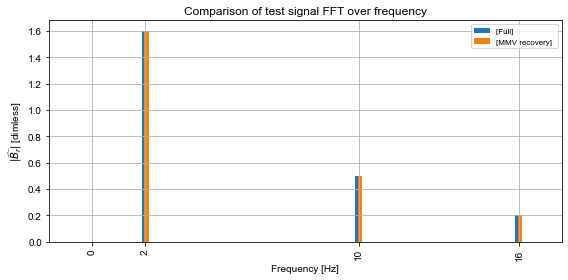

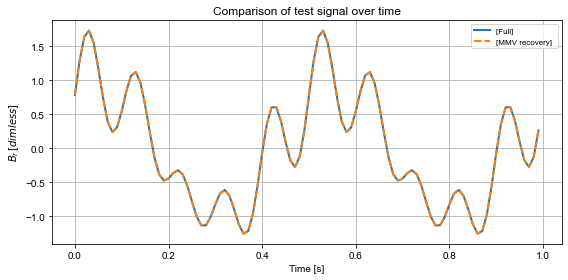

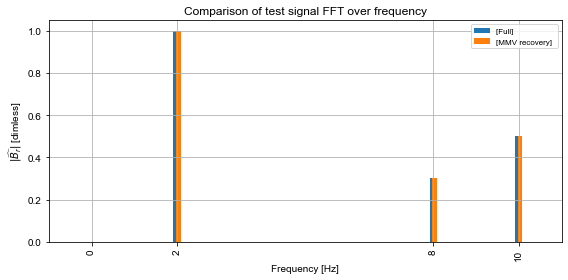

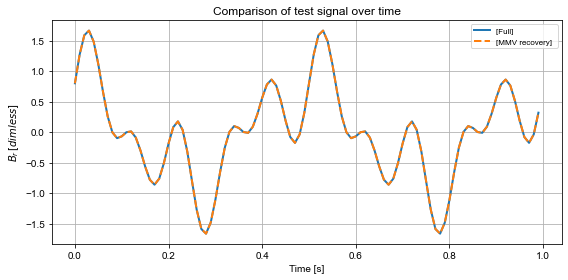

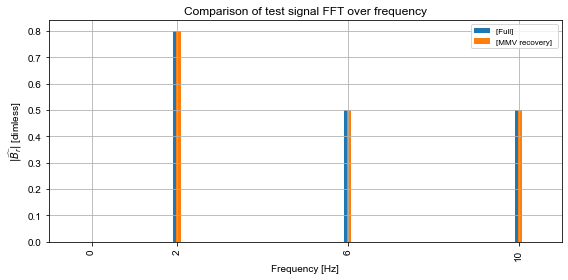

In [ ]:
Signal_reconstruit_1 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=s1,
    is_real=True,
)

Signal_reconstruit_2 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=s2,
    is_real=True,
)

Signal_reconstruit_3 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=s3,
    is_real=True,
)

Signal_reconstruit_4 = DataTime(
    name="Test signal",
    symbol="B_r",
    unit="dimless",
    axes=[Time],
    values=s4,
    is_real=True,
)

Signal_1.plot_2D_Data("time",data_list=[Signal_reconstruit_1],legend_list=["Full","MMV recovery"],linestyles=["-","--"])
Signal_1.plot_2D_Data("freqs",data_list=[Signal_reconstruit_1],legend_list=["Full","MMV recovery"],linestyles=["-","--"])

Signal_2.plot_2D_Data("time",data_list=[Signal_reconstruit_2],legend_list=["Full","MMV recovery"],linestyles=["-","--"])
Signal_2.plot_2D_Data("freqs",data_list=[Signal_reconstruit_2],legend_list=["Full","MMV recovery"],linestyles=["-","--"])

Signal_3.plot_2D_Data("time",data_list=[Signal_reconstruit_3],legend_list=["Full","MMV recovery"],linestyles=["-","--"])
Signal_3.plot_2D_Data("freqs",data_list=[Signal_reconstruit_3],legend_list=["Full","MMV recovery"],linestyles=["-","--"])

Signal_4.plot_2D_Data("time",data_list=[Signal_reconstruit_4],legend_list=["Full","MMV recovery"],linestyles=["-","--"])
Signal_4.plot_2D_Data("freqs",data_list=[Signal_reconstruit_4],legend_list=["Full","MMV recovery"],linestyles=["-","--"])
